In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
# Set random seed for reproducabiliy
np.random.seed(5)

In [3]:
def load_xray_data(path):
    # Create datalist and error counter
    imported_data = []
    num_errors = 0
    
    for directory in os.listdir(path):
        sub_path = path + "/" + directory
        
        if ".DS_Store" in sub_path:
            continue
    
        # Loop through all subdirectories
        for image in os.listdir(sub_path):
            img_path = sub_path + "/" + image
    
            if ".DS_Store" in img_path:
                continue

            # Load in the image
            img_arr = cv2.imread(img_path)
            # Try to resize it to the TARGET_IMAGE_SIZE variable
            try:
                img_arr = cv2.resize(img_arr, TARGET_IMAGE_SIZE)
                imported_data.append(img_arr)
            # If an exception occurs, omit it and continue
            except Exception as e:
                num_errors += 1
                continue
            
    
    return imported_data, num_errors

In [4]:
print("Loading X-Ray data...")
path = "../data/raw/xray_data/"
model_type = "xr"
# We define the target image size as 128x128 pixels
TARGET_IMAGE_SIZE = (128, 128)
imported_data, num_errors = load_xray_data(path)

print(f"\tLoaded a total of {len(imported_data)} files.\nNum. Errors: {num_errors}")

Loading X-Ray data...
	Loaded a total of 15153 files.
Num. Errors: 0


In [5]:
images_norm = np.array(imported_data)

images_norm = images_norm / 255.0

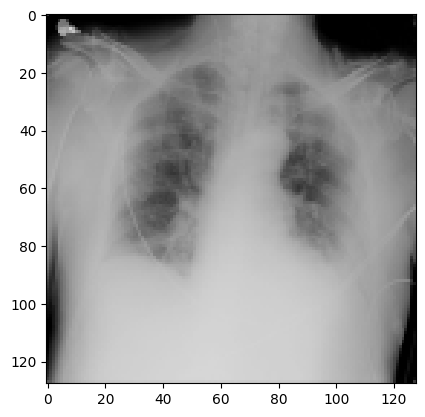

In [6]:
plt.imshow(images_norm[0], interpolation='nearest')
plt.show()

In [7]:
data_generator = ImageDataGenerator(rescale = 1./255)
dataset_labels = data_generator.flow_from_directory(path,
                                                    target_size = TARGET_IMAGE_SIZE,
                                                    batch_size = 32,
                                                    class_mode = 'sparse')

# Get a list of the class labels from the ImageDataGenerator object
class_labels = dataset_labels.classes

print(f"\nIdentified Class Labels: {dataset_labels.class_indices}")

Found 15153 images belonging to 3 classes.

Identified Class Labels: {'COVID': 0, 'Normal': 1, 'Viral Pneumonia': 2}


In [8]:
sample_sizes = [3616, 10192, 1345]
# Create arrays of indices for each class
indices_covid19 = np.where(class_labels == 0)[0]
indices_healthy = np.where(class_labels == 1)[0]
indices_viral_pneumonia = np.where(class_labels == 2)[0]

# Determine the minimum number of samples among all classes
min_sample_size = min(sample_sizes)

# Randomly sample data for each class to achieve balance
indices_covid19_sampled = np.random.choice(indices_covid19, min_sample_size, replace=False)
indices_healthy_sampled = np.random.choice(indices_healthy, min_sample_size, replace=False)
indices_viral_pneumonia_sampled = np.random.choice(indices_viral_pneumonia, min_sample_size, replace=False)

# Combine the sampled indices for all classes
indices_combined = np.concatenate(
    [indices_covid19_sampled, indices_healthy_sampled, indices_viral_pneumonia_sampled]
)

# Use the combined indices to create a balanced dataset
balanced_data = images_norm[indices_combined]
balanced_labels = class_labels[indices_combined]

In [9]:
# Convert class labels to numerical labels using LabelEncoder
label_encoder = LabelEncoder()
y_numerical = label_encoder.fit_transform(balanced_labels)

# Convert numerical labels to one-hot encoded format
num_classes = len(label_encoder.classes_)
y_onehot = to_categorical(y_numerical, num_classes)

In [10]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(balanced_data, y_onehot, test_size=0.2, stratify=y_onehot, random_state=5)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.05, random_state=5)

print(f"Train Size (x, y): {x_train.shape[0],y_train.shape[0]}")
print(f"Validation Size (x, y): {x_val.shape[0],y_val.shape[0]}")
print(f"Test Size (x, y): {x_test.shape[0],y_test.shape[0]}")

Train Size (x, y): (3066, 3066)
Validation Size (x, y): (162, 162)
Test Size (x, y): (807, 807)


In [11]:
#Function to build the more complex CNN model
def build_model(hp):
    model = Sequential()

    # First convolutional block
    model.add(Conv2D(hp.Int('filters_1', min_value=32, max_value=128, step=32), 
                     (hp.Int('kernel_height_1', min_value=3, max_value=5), hp.Int('kernel_width_1', min_value=3, max_value=5)),
                     activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(hp.Choice('pool_height_1', values=[2, 3]), hp.Choice('pool_width_1', values=[2, 3]))))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Second convolutional block
    model.add(Conv2D(hp.Int('filters_2', min_value=32, max_value=128, step=32), 
                     (hp.Int('kernel_height_2', min_value=3, max_value=5), hp.Int('kernel_width_2', min_value=3, max_value=5)),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(hp.Choice('pool_height_2', values=[2, 3]), hp.Choice('pool_width_2', values=[2, 3]))))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    # Third convolutional block
    model.add(Conv2D(hp.Int('filters_3', min_value=32, max_value=128, step=32), 
                     (hp.Int('kernel_height_3', min_value=3, max_value=5), hp.Int('kernel_width_3', min_value=3, max_value=5)),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(hp.Choice('pool_height_3', values=[2, 3]), hp.Choice('pool_width_3', values=[2, 3]))))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Flatten())
    
    # Dense layers
    model.add(Dense(hp.Int('dense_units_1', min_value=256, max_value=512, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout_4', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(hp.Int('dense_units_2', min_value=128, max_value=256, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout_5', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.0001, 0.00001]))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [12]:
# Define the tuner with an increased number of trials
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,
    directory='hyperparameter_tuning',
    project_name='cnn_xray_search'
)

In [13]:
# Search for the best hyperparameters
tuner.search(x_train, y_train, epochs=15, validation_data=(x_val, y_val))

Trial 50 Complete [00h 11m 01s]
val_accuracy: 0.8641975522041321

Best val_accuracy So Far: 0.9197530746459961
Total elapsed time: 10h 18m 49s
INFO:tensorflow:Oracle triggered exit


In [14]:
# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Train the best model on the full training set
best_model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=2)

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy:", test_accuracy)

Epoch 1/50
96/96 - 81s - loss: 0.2684 - accuracy: 0.8940 - 81s/epoch - 844ms/step
Epoch 2/50
96/96 - 80s - loss: 0.2595 - accuracy: 0.8966 - 80s/epoch - 837ms/step
Epoch 3/50
96/96 - 80s - loss: 0.2288 - accuracy: 0.9145 - 80s/epoch - 836ms/step
Epoch 4/50
96/96 - 80s - loss: 0.2002 - accuracy: 0.9194 - 80s/epoch - 837ms/step
Epoch 5/50
96/96 - 81s - loss: 0.1943 - accuracy: 0.9269 - 81s/epoch - 840ms/step
Epoch 6/50
96/96 - 80s - loss: 0.1799 - accuracy: 0.9273 - 80s/epoch - 837ms/step
Epoch 7/50
96/96 - 80s - loss: 0.1996 - accuracy: 0.9191 - 80s/epoch - 835ms/step
Epoch 8/50
96/96 - 80s - loss: 0.1879 - accuracy: 0.9305 - 80s/epoch - 837ms/step
Epoch 9/50
96/96 - 80s - loss: 0.1644 - accuracy: 0.9344 - 80s/epoch - 836ms/step
Epoch 10/50
96/96 - 80s - loss: 0.1500 - accuracy: 0.9432 - 80s/epoch - 836ms/step
Epoch 11/50
96/96 - 80s - loss: 0.1519 - accuracy: 0.9390 - 80s/epoch - 836ms/step
Epoch 12/50
96/96 - 80s - loss: 0.1412 - accuracy: 0.9449 - 80s/epoch - 835ms/step
Epoch 13/50
9

In [16]:
if input("Save best model (y/n): ").lower() == "y":
    out_name = input("\tModel Name: ")
    best_model.save(f'../models/{out_name}.h5')
    print("\tModel saved!")
else:
    print("\tModel not saved!")

Save best model (y/n):  y
	Model Name:  xr-hpo-91


	Model saved!


C:\Users\simon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
